# Fraud Investigation on the Enron Email and Financial Dataset

---

## Introducing the Dataset

In late 2001, Enron, an American energy company, filed for bankruptcy after one of the largest financial scandals in corporate history. After the company's collapse, over 600,000 emails generated by 158 Enron employees - now known as the Enron Corpus - were acquired by the Federal Energy Regulatory Commission during its investigation. The data was then uploaded online, and since then, a number of people and organizations have graciously prepared, cleaned and organized the dataset that is available to the public today (a few years later, financial data of top Enron executives were released following their trial).

Today, the Enron Corpus is the largest and one of the only publicly available mass collections of real emails easily accessible for study. This excerpt from an [article](https://www.technologyreview.com/s/515801/the-immortal-life-of-the-enron-e-mails/) in MIT Technology Review summarizes the value of such a dataset:

> This corpus is valuable to computer scientists and social-network theorists in ways that the e-mails’ authors and recipients never could have intended. Because it is a rich example of how real people in a real organization use e-mail—full of mundane lunch plans, boring meeting notes, embarrassing flirtations that revealed at least one extramarital affair, and the damning missives that spelled out corruption—it has become the foundation of hundreds of research studies in fields as diverse as machine learning and workplace gender studies.

The [dataset](https://www.cs.cmu.edu/~enron/enron_mail_20150507.tar.gz) contains the emails, metadata about the emails such as number received by and sent from each individual, and financial information including salary and stock options. The objective of this project was to create a machine learning model that could separate out the Persons of Interest. Persons of interest are the individuals who were eventually tried for fraud or criminal activity in the Enron investigation and include [several top level executives](http://www.nytimes.com/2006/01/29/business/businessspecial3/10-enron-players-where-they-landed-after-the-fall.html).

Utilizing the [scikit-learn](http://scikit-learn.org/stable/) library and machine learning principles, I built a "person of interest" (POI) identifier to detect and predict culpable Enron employees, using features from financial data, email data, and labeled data--POIs who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

## Initial Features Definition, Data Cleansing, Outlier Investigation and Feature Analysis

The data is provided in the form of a Python dictionary with each individual as a key and the information about the indvidual as values. Initial features were manually selected and categorized from columns presented in the [official insider payments document](enron_insiderpay.pdf).

In [1]:
import sys
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from feature_format import featureFormat, targetFeatureSplit
from verify import dump_classifier_and_data, test_classifier

### Task 1: Select and categorize the features manually 
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi" (explained in feature_format.py).

target_label = 'poi'

payment_data = ['salary',
                'bonus',
                'long_term_incentive',
                'deferred_income',
                'deferral_payments',
                'loan_advances',
                'other',
                'expenses',                
                'director_fees', 
                'total_payments']

stock_data = ['exercised_stock_options',
              'restricted_stock',
              'restricted_stock_deferred',
              'total_stock_value']

email_data = ['to_messages',
              'from_messages',
              'from_poi_to_this_person',
              'from_this_person_to_poi',
              'shared_receipt_with_poi']
              
              
features_list = [target_label] + payment_data + stock_data + email_data

### Load the dictionary containing the dataset
with open("Enron_Dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

df = pd.DataFrame.from_dict(data_dict, orient='index')
df = df.replace('NaN', np.nan)
df = df[features_list]

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 20 columns):
poi                          146 non-null bool
salary                       95 non-null float64
bonus                        82 non-null float64
long_term_incentive          66 non-null float64
deferred_income              49 non-null float64
deferral_payments            39 non-null float64
loan_advances                4 non-null float64
other                        93 non-null float64
expenses                     95 non-null float64
director_fees                17 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
to_messages                  86 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-null float

We can see that the dataset is quite sparse with some variables like `total_payments` and `total_stock_value` having values for most of the employees but some others like `loan_advances` and `director_fees` that we have information for too few employees.

In [3]:
df.describe()

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
count,9.500000e+01,8.200000e+01,6.600000e+01,4.900000e+01,3.900000e+01,4.000000e+00,9.300000e+01,9.500000e+01,1.700000e+01,1.250000e+02,1.020000e+02,1.100000e+02,1.800000e+01,1.260000e+02,86.000000,86.000000,86.000000,86.000000,86.000000
mean,5.621943e+05,2.374235e+06,1.470361e+06,-1.140475e+06,1.642674e+06,4.196250e+07,9.190650e+05,1.087289e+05,1.668049e+05,5.081526e+06,5.987054e+06,2.321741e+06,1.664106e+05,6.773957e+06,2073.860465,608.790698,64.895349,41.232558,1176.465116
std,2.716369e+06,1.071333e+07,5.942759e+06,4.025406e+06,5.161930e+06,4.708321e+07,4.589253e+06,5.335348e+05,3.198914e+05,2.906172e+07,3.106201e+07,1.251828e+07,4.201494e+06,3.895777e+07,2582.700981,1841.033949,86.979244,100.073111,1178.317641
min,4.770000e+02,7.000000e+04,6.922300e+04,-2.799289e+07,-1.025000e+05,4.000000e+05,2.000000e+00,1.480000e+02,3.285000e+03,1.480000e+02,3.285000e+03,-2.604490e+06,-7.576788e+06,-4.409300e+04,57.000000,12.000000,0.000000,0.000000,2.000000
25%,2.118160e+05,4.312500e+05,2.812500e+05,-6.948620e+05,8.157300e+04,1.600000e+06,1.215000e+03,2.261400e+04,9.878400e+04,3.944750e+05,5.278862e+05,2.540180e+05,-3.896218e+05,4.945102e+05,541.250000,22.750000,10.000000,1.000000,249.750000
50%,2.599960e+05,7.693750e+05,4.420350e+05,-1.597920e+05,2.274490e+05,4.176250e+07,5.238200e+04,4.695000e+04,1.085790e+05,1.101393e+06,1.310814e+06,4.517400e+05,-1.469750e+05,1.102872e+06,1211.000000,41.000000,35.000000,8.000000,740.500000
75%,3.121170e+05,1.200000e+06,9.386720e+05,-3.834600e+04,1.002672e+06,8.212500e+07,3.620960e+05,7.995250e+04,1.137840e+05,2.093263e+06,2.547724e+06,1.002370e+06,-7.500975e+04,2.949847e+06,2634.750000,145.500000,72.250000,24.750000,1888.250000
max,2.670423e+07,9.734362e+07,4.852193e+07,-8.330000e+02,3.208340e+07,8.392500e+07,4.266759e+07,5.235198e+06,1.398517e+06,3.098866e+08,3.117640e+08,1.303223e+08,1.545629e+07,4.345095e+08,15149.000000,14368.000000,528.000000,609.000000,5521.000000


In [4]:
df.shape

(146, 20)

### Data Cleansing

From the info about the dataset, I can see that all the fields are floating point numbers except for the `poi` identification which is True/False. There are 146 rows in the dataframe which most likely mean there are 146 individuals’ information. Some of the maximum values seem unreasonable such the `total_payments` which is $309 million or the `to_messages` at 15,000! Those could be valid values, but they look suspicious on a first pass through the information.

Another observation is that the financial and email fields seem to be bereft with NaNs.

In [5]:
print("Amount of NaN values in the dataset: {}".format(df.isnull().sum().sum()))

Amount of NaN values in the dataset: 1323


According to the [official insider payments document](enron_insiderpay.pdf) for the financial (payment and stock) data, values of NaN represent 0 and not unknown quantities. That's why I replace all NaNs with 0.

In [6]:
from sklearn.preprocessing import scale, Imputer

# Fill in the missing financial data with zeros
df[payment_data] = df[payment_data].fillna(value=0)
df[stock_data] = df[stock_data].fillna(value=0)

However, for the email data, NaNs are unknown information. I'm going to split the data into 2 classes: POI/non-POI and impute the missing values with mean of each class. 

If I chose to drop all NaNs, that would reduce the size of what is already a small dataset. As the [quality of a machine learning model is proportional to the amount of data fed into it](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf), I am hesitant to remove any information that could possibly be of use.

In [7]:
# Fill in the missing email meta-data with the median for poi or nonpoi
imp = Imputer(missing_values='NaN', strategy = 'median', axis=0)

df_poi = df[df['poi'] == True]
df_nonpoi = df[df['poi'] == False]
df = df.copy()

df_poi.loc[:, email_data] = imp.fit_transform(df_poi.loc[:, email_data])

df_nonpoi.loc[:, email_data] = imp.fit_transform(df_nonpoi.loc[:, email_data])

df = df_poi.append(df_nonpoi)

I'm going to check the accuracy of the financial data by summing up the **payment_data** features and comparing it with the `total_payments` feature and **stock_data** features and comparing with the `total_stock_value`.

In [8]:
errors = (df[df[payment_data[:-1]].sum(axis='columns') != df['total_payments']])
errors

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
BELFER ROBERT,False,0.0,0.0,0.0,0.0,-102500.0,0.0,0.0,0.0,3285.0,102500.0,3285.0,0.0,44093.0,-44093.0,944.0,41.0,26.5,6.0,594.0
BHATNAGAR SANJAY,False,0.0,0.0,0.0,0.0,0.0,0.0,137864.0,0.0,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,0.0,523.0,29.0,0.0,1.0,463.0


In [9]:
errors = (df[df[stock_data[:-1]].sum(axis='columns') != df['total_stock_value']])
errors

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
BELFER ROBERT,False,0.0,0.0,0.0,0.0,-102500.0,0.0,0.0,0.0,3285.0,102500.0,3285.0,0.0,44093.0,-44093.0,944.0,41.0,26.5,6.0,594.0
BHATNAGAR SANJAY,False,0.0,0.0,0.0,0.0,0.0,0.0,137864.0,0.0,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,0.0,523.0,29.0,0.0,1.0,463.0


The data above seems to represent the mismatch between the sum of each individual's payments and total payments. Closer inspection reveals the errors to be caused by a misalignment of the columns; for `Robert Belfer`, the financial data has been shifted one column to the right, and for `Sanjay Bhatnagar`, the data has been shifted one column to the left. These observations can be verified against their corresponding rows in the [official insider payments document](enron_insiderpay.pdf).

In [10]:
# Fix the errors that were found in the data 
# Retrieve Belfer's incorrect data 
belfer_financial = df.iloc[df.index.get_loc('BELFER ROBERT'), 1:15].tolist()
# Delete the first element to shift left and add on a 0 to end as indicated in financial data
belfer_financial.pop(0)
belfer_financial.append(0)
# Reinsert corrected data
df.iloc[df.index.get_loc('BELFER ROBERT'), 1:15] = belfer_financial

# Retrieve Bhatnagar's incorrect data  
bhatnagar_financial = df.iloc[df.index.get_loc('BHATNAGAR SANJAY'), 1:15].tolist()
# Delete the last element to shift right and add on a 0 to beginning
bhatnagar_financial.pop(-1)
bhatnagar_financial = [0] + bhatnagar_financial
# Reinsert corrected data
df.iloc[df.index.get_loc('BHATNAGAR SANJAY'), 1:15] = bhatnagar_financial

In [11]:
# Verify persisting payment data errors(if any)
len(df[df[payment_data[:-1]].sum(axis='columns') != df['total_payments']])

0

In [12]:
# Verify persisting stock data errors(if any)
len(df[df[stock_data[:-1]].sum(axis='columns') != df['total_stock_value']])

0

### Outlier Investigation

**Payment Data Features**: `bonus` and `salary`

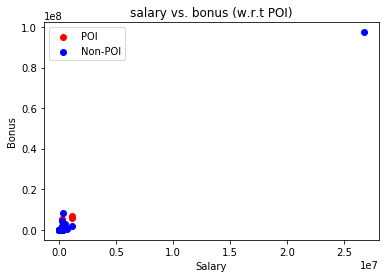

In [13]:
plt.scatter(df['salary'][df['poi'] == True],df['bonus'][df['poi'] == True], color = 'r',
           label = 'POI')
plt.scatter(df['salary'][df['poi'] == False],df['bonus'][df['poi'] == False],color = 'b',
           label = 'Non-POI')
    
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("salary vs. bonus (w.r.t POI)")
plt.legend(loc='upper left')
plt.show()

The above figure suggests a point having very high values for salary and bonus.

In [14]:
# Investigating the non-POI enitity with exorbitant salary value
df['salary'].argmax()

'TOTAL'

**Removing Outlier 1**: `TOTAL`

The removal of `TOTAL` is absolutely essential to prevent aberrations in the predictions.

In [15]:
df.drop(axis=0, labels = 'TOTAL', inplace=True)

**Removing Outlier 2**: `THE TRAVEL AGENCY IN THE PARK`

The [official insider payments document](enron_insiderpay.pdf) and the documentary [Enron The Smartest Guys In The Room](https://www.youtube.com/watch?v=BIwFO4_SWQQ) seems to suggest that the row `THE TRAVEL AGENCY IN THE PARK` was a company co-owned by Enron's former Chairman's sister who seems like an anomaly in the dataset.

In [16]:
# Features of 'THE TRAVEL AGENCY IN THE PARK'
df.loc['THE TRAVEL AGENCY IN THE PARK']

poi                           False
salary                            0
bonus                             0
long_term_incentive               0
deferred_income                   0
deferral_payments                 0
loan_advances                     0
other                        362096
expenses                          0
director_fees                     0
total_payments               362096
exercised_stock_options           0
restricted_stock                  0
restricted_stock_deferred         0
total_stock_value                 0
to_messages                     944
from_messages                    41
from_poi_to_this_person        26.5
from_this_person_to_poi           6
shared_receipt_with_poi         594
Name: THE TRAVEL AGENCY IN THE PARK, dtype: object

In [17]:
# Deleting the outlier'THE TRAVEL AGENCY IN THE PARK'
df.drop('THE TRAVEL AGENCY IN THE PARK', axis = 0, inplace = True)

I can now look for outlying data points recorded in the different fields. A conservative approach to removal of outliers would be ideal since the dataset being used in our case is relatively small for machine learning. Also the pattern of the data represented by the outliers could proffer insights to identify persons of interest (POIs). 

Integrating the concept of mild outliers and computation of each person's outliers will throw some light on removal of certain individuals with extremely high outlier counts.

The [official definition of a mild outlier](http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm) is either below the (first quartile  minus 1.5 times the Interquartile Range (IQR))  or  above the (third quartile plus 1.5 times the IQR):

$$ low\ outlier < first\ quartile - 1.5\ x\ IQR $$

$$ high\ outlier > third\ quartile + 1.5\ x\ IQR $$

My approach will be to count the number of outlying features for each individual. I will then investigate the persons with the highest number of outliers to determine if they need to be removed.

In [18]:
IQR = df.quantile(q=0.75) - df.quantile(q=0.25)
first_quartile = df.quantile(q=0.25)
third_quartile = df.quantile(q=0.75)
outliers = df[(df>(third_quartile + 1.5*IQR) ) | (df<(first_quartile - 1.5*IQR) )].count(axis=1)
outliers.sort_values(axis=0, ascending=False, inplace=True)
outliers.head(12)

LAY KENNETH L         15
FREVERT MARK A        13
SKILLING JEFFREY K    13
BELDEN TIMOTHY N      10
LAVORATO JOHN J        8
HAEDICKE MARK E        8
WHALLEY LAWRENCE G     8
BUY RICHARD B          8
BAXTER JOHN C          8
KEAN STEVEN J          7
DELAINEY DAVID W       7
KITCHEN LOUISE         6
dtype: int64

As this point, I need to do some research before blinding deleting outliers. Based on the small number of persons of interest initially in the dataset, I decided not to remove any individuals who are persons are interest regardless of their number of outliers. An outlier for a person of interest could be a sign of fradulent activity, such as evidence that someone is laundering illicit funds through the company payroll or is paying an accomplice to remain silent about illegal activity. I will manually examine several of the top outlying inviduals to see if I can glean any insights and to determine whom to remove.

### Outlier Findings

1. Kenneth Lay, [the CEO of Enron from 1986-2001](http://www.biography.com/people/kenneth-lay-234611), presided over many of the illegal business activites and is one of the most important persons of interest. 
2. Mark Frevert served as chief executive of [Enron Europe from 1986-2000 and was appointed as chairman of Enron in 2001](http://www.risk.net/risk-management/2123422/ten-years-after-its-collapse-enron-lives-energy-markets). He was a major player in the firm, although not a person of interest. He is not representative of the average employee at Enron during this time because of his substantial compensation and hence will remove him from the dataset. 
3. Timothy Belden was the [former head of trading for Enron](http://articles.latimes.com/2007/feb/15/business/fi-enron15) who developed the strategy to illegally raise energy prices in California. He was a person of interest and will definitely remain in the dataset. 
4. Jeffrey Skilling [replaced Kenneth Lay as CEO of Enron in 2001 and orchestrated much of the fraud](http://www.biography.com/people/jeffrey-skilling-235386) that destroyed Enron. A definite person of interest.
5. John Baxter was a former vice Enron vice chairman and [died of an apparent self-inflicted gunshot](https://www.wsws.org/en/articles/2002/01/enro-j28.html) before he was able to testify against other Enron executives. He is not a person of interest. 
6. John Lavorato was a top executive in the energy-trading branch of Enron and received large bonuses to [keep him from leaving Enron](http://www.nytimes.com/2002/06/18/business/officials-got-a-windfall-before-enron-s-collapse.html). He wasn't a person of interest, and the large bonus ended up skewing his total pay.
7. Lawrence Whalley [served as the president of Enron](http://www.corpwatch.org/article.php?id=13194) and fired Andrew Fastow once it was apparent the severity of Enron's situation. He was investigated thoroughly but not identified as a person of interest.  



In total, I decided to remove four people from the dataset. I believe these removals are justified primarily because none of these individuals were persons of interest and they all were upper-level executives with pay levels far above the average employee. I do not think these top executives who did not commit fraud are indicative of the majority of employees at Enron who also did nothing illegal (i.e. they were not persons of interest).

In [19]:
# Drop outliers
df.drop(axis=0, labels=['FREVERT MARK A', 'LAVORATO JOHN J', 'WHALLEY LAWRENCE G', 'BAXTER JOHN C'], inplace=True)

In [20]:
# Verify outlier elimination
len(df)

140

In [21]:
# Computing total poi and non-poi currently in the dataset
df['poi'].value_counts()

False    122
True      18
Name: poi, dtype: int64

The above analysis throws light on the number of pois in our dataset, which is 18.

In [22]:
df.isnull().sum().sum()

0

In [23]:
df[df==0].count().sum()

1150

There are a total of 2800 observations of financial and email data in the set now that the data cleaning has been finished. Of these, __1150 or 41%__ are 0 for financial (payment and stock) values. There are 18 persons of interest, comprising __12.9%__ of the individuals. 

## Initial Algorithm Training and Performance Metrics

The first training and testing will be done on all of the initial features in the dataset. This is in order to gauge the importance of the features and to serve a baseline to observe the performance before any feature selection or parameter tuning. 

The four algorithms I have selected for initial testing are:
- `Gaussian Naive Bayes Classifier`
- `Decision Tree Classifier`
- `Support Vector Machine Classifier`
- `K-Means Clustering Classifier`

I will run the algorithms with their default parameters except for the `Support Vector Machine` I will alter the kernel to be linear and for `K-Means Clustering` I will select `number of clusters` = 2, as the focus here is the binary classification of the target categories. 

Although accuracy would appear to be the obvious choice for evaluating the quality of a classifier, accuracy can be a crude measure at times, and is not suited for some datasets including the Enron one. For example, if a classifier were to guess that all of the samples in the cleaned dataset were _not_ persons of interest, it would have an accuracy of 87.1%. However, this clearly would not satisfy the objective of this investigation which is to create a classifier that can identify _persons of interest_.

Therefore, different metrics are needed to evaluate the classifiers to gauge their performance. The two selected for use in this project are [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall).

* `Precision` is the number of correct positive classifications divided by the total number of positive labels assigned. In other words, it is the fraction of persons of interest predicted by the algorithm that are truly persons of interest.  Mathematically precision is defined as 

$$ precision = \frac{true\ positives}{true\ positives + false\ positives} $$

* `Recall` is the number of correct positive classifications divided by the number of positive instances that should have been identified. In other words, it is the fraction of the total number of persons of interestin the data that the classifier identifies. Mathematically, recall is defined as

\\[ recall = \frac{true\ positives}{true\ positives + false\ negatives} \\]

Precision is also known as positive predictive value while recall is called the sensitivity of the classifier. 

A combined measured of precision and recall is the [`F1 score`](https://en.wikipedia.org/wiki/F1_score). Is it the harmonic mean of precision and recall. Mathematically, the F1 score is defined as:

\\[ F1\ Score = \frac{2\ (precision\ x\ recall)}{precision + recall} \\]

In the context of Enron data, the precision score measures the algorithm's ability to, given that it is predicting a POI, correctly predicts a POI. While the recall score measures the algorithm's ability to, given that it is a POI, correctly predicts a POI. The difference will be clearer once the true positives, false positives, true negatives and false negatives are defined in this context:

- **True positive**: when a label is a POI and the algorithm predicts it is a POI.
- **False positive**: when a label is not a POI and the algorithm predicts it is a POI.
- **True negative**: when a label is not a POI and the algorithm predicts a non-POI.
- **False negative**: when a label is not a POI and the algorithm predicts a POI.

So, the the precision score is how often the algorithm is getting the prediction of POI right, whereas the recall score is, given that the label is a POI, how often the algorithm predicts it is.

For this project, the objective was to obtain a precision and a recall score greater than 0.3. However, I believe a better performance is possible with the right feature selection and algorithm tuning. For the majority of my tuning and optimization using `GridSearchCV`, I will use the F1 score because it takes into account both the precision and recall. 

## Scaling 

The only data preparation I will do for initial testing of the algorithms is to scale the data such that it has a zero mean and a unit variance. This process is called [normalization](http://www.analytictech.com/ba762/handouts/normalization.htm) and is accomplished using the scale function from the sklearn preprocessing module.

Scaling of some form (whether that is `MinMax` scaling or normalization) is usually necessary because there are different units for the features in the dataset. Scaling creates non-dimensional features so that features with larger units do not have an undue influence on the classifier as would be the case if the classifier used some sort of distance measurement (such as Euclidean distance) as a similarity metric. 

[Here is a good dicussion of feature scaling and normalization](https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data). 

In [24]:
from sklearn.preprocessing import scale
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
import verify

# Scale data frame 
scaled_df = df.copy()
scaled_df.iloc[:,1:] = scale(scaled_df.iloc[:,1:])

# Create my_dataset
my_dataset = scaled_df.to_dict(orient='index')

Code to left-align tables:

In [25]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

### Gaussian Naive Bayes Classifier

In [26]:
# Create and test the Gaussian Naive Bayes Classifier
clf = GaussianNB()
verify.dump_classifier_and_data(clf, my_dataset, features_list)
verify.main()

	Accuracy: 0.71429	Precision: 0.31481	Recall: 0.85000	F1: 0.45946	F2: 0.63433
	Total predictions:  140	True positives:   17	False positives:   37	False negatives:    3	True negatives:   83



### Decision Tree Classifier

In [27]:
# Create and test the Decision Tree Classifier
clf = DecisionTreeClassifier()
verify.dump_classifier_and_data(clf, my_dataset, features_list)
verify.main()

	Accuracy: 0.85714	Precision: 0.50000	Recall: 0.55000	F1: 0.52381	F2: 0.53922
	Total predictions:  140	True positives:   11	False positives:   11	False negatives:    9	True negatives:  109



### Support Vector Machine Classifier

In [28]:
# Create and test the Support Vector Machine Classifier
clf = SVC(kernel='linear')
verify.dump_classifier_and_data(clf, my_dataset, features_list)
verify.main()

	Accuracy: 0.85000	Precision: 0.42857	Recall: 0.15000	F1: 0.22222	F2: 0.17241
	Total predictions:  140	True positives:    3	False positives:    4	False negatives:   17	True negatives:  116



### K-Means Clustering Classifier

In [29]:
# Create and test the K-Means Clustering Classifier
clf = KMeans(n_clusters=2)
verify.dump_classifier_and_data(clf, my_dataset, features_list)
verify.main()

	Accuracy: 0.77857	Precision: 0.17647	Recall: 0.15000	F1: 0.16216	F2: 0.15464
	Total predictions:  140	True positives:    3	False positives:   14	False negatives:   17	True negatives:  106



### Comparing the classifiers

The results from running the four classifiers on the entire initial features set with no parameter tuning are summarized in the table below.

| Classifier            | Precision | Recall  | F1 Score | Accuracy |
|-----------------------|-----------|---------|----------|----------|
| GaussianNB            | 0.31481   | 0.85000 | 0.45946  | 0.71429  |
| DecisionTree          | 0.50000   | 0.55000 | 0.52381  | 0.85714  |
| SVC (kernel='linear') | 0.42857   | 0.15000 | 0.22222  | 0.85000  |
| KMeans (n_clusters=2) | 0.17647   | 0.15000 | 0.16216  | 0.77857  |

From the first run through the four algorithms, I can see that the `Decision Tree Classifier` performed best, followed by the `Gaussian Naive Bayes Classifier`, `Support Vector Machine Classifier` and the `K-Means Clustering Classifier`. 

In fact, the `Decision Tree Classifier` and `Gaussian Naive Bayes Classifier` both perform well enough to meet the standards for the project. Nonetheless, there is room for improvement in these metrics. 

## Validation

The validation strategy used here is a form of cross-validation that is implemented in the provided [`verify.py`](verify.py) script. 

[Cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) performs multiple splits on the dataset and in each split, forms a different training and testing set. For each iteration, the classifier is fit on a training set and then tested on a testing set. For the next iteration, the classifier is again trained and tested, but on different sets and this process continues for the number of splits made of the dataset. 

Cross-validation prevents one from making the classic mistake of training an algoithm on the same data used to test the algorithm. If this happens, the test results may show that the classifier is accurate, but that is only because the algorithm has seen the testing data before. When the classifier is deployed on novel samples (implemented in the real world), the performance may be poor because it was trained and tuned for a very specific set of instances. The classifier will not be able to generalize to new cases becuase it is only fit and tuned to the specific samples it is tested on. Cross-validation solves this issue by training and testing on multiple different subsets of the features and labels and is ideal for use on small datasets to avoid overfitting. 

Throughout my analysis, I used cross-validation to assess the performance of my algorithms. The [`verify.py`](verify.py) script uses the [`StratifiedShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) cross-validation method, and `GridSearchCV`, which is used to find the optimal number of features and the best parameters, which employs cross validation with the [`StratifiedKFolds`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) cross-validator. In both cases, the dataset is split 10 times into training and testing sets.

## Feature Engineering 

The next step is to create new features from the existing information that could possibly improve performance. I will also need to carry out feature selection to remove those features that are not useful for predicting a person of interest.

Three new features will be created from the email metadata. The first is the ratio of emails to an individual from a POI to all emails addressed to that person, the second is the same but for messages to POI, and the third is the ratio of email receipts shared with a POI to all emails addressed to that individual. 

The rationale behind these choices is that the absolute number of emails from or to a POI is irrelevant compared to the relative number considering the total emails an individual sends or receives. People who interact more with a POI (as indicated by emails) are themselves more likely to be a POI because the fraud was not committed alone. The possibility of certain innocent people having interacted with POIs cannot be ruled out.

In [30]:
# Create the new email features and add to the dataframe
df['to_poi_ratio'] = df['from_poi_to_this_person'] / df['to_messages']
df['from_poi_ratio'] = df['from_this_person_to_poi'] / df['from_messages']
df['shared_poi_ratio'] = df['shared_receipt_with_poi'] / df['to_messages']

# Add new email features to the features list
features_list.append('to_poi_ratio')
features_list.append('from_poi_ratio')
features_list.append('shared_poi_ratio')

At this point I will also create new features using the financial data. I have a few theories that I formed from my initial data exploration of the Enron case. 

I think that people recieving large bonuses are more likely to be persons of interest because the bonuses could be a result of fraudulent activity. It would be easier to pass off illegal funds as a bonus rather than a salary raise which usually involves a contract and input from shareholders. 

The two new features will be the bonus in relation to the salary and the bonus in relation to total payments. 

There are now a total of 25 features, some of which are most likely redudant or not of any value. I will perform feature reduction/selection to optimize the number of features so I am not worried about the initial large number of features. Moreover, the algorithms I am using are able to train relatively quickly even with the large number of features because the total number of data samples is small.

In [33]:
# Create the new financial features and add to the dataframe
df['bonus_to_salary'] = df['bonus'] / df['salary']
df['bonus_to_total'] = df['bonus'] / df['total_payments']

# Add new financial features to the features list
features_list.append('bonus_to_salary')
features_list.append('bonus_to_total')   

In [35]:
# Fill any NaN financial data with a 0
df.fillna(value = 0, inplace=True)

# Create a copy of the dataframe and normalize it to zero mean and unit variance 
scaled_df = df.copy()
scaled_df.iloc[:,1:] = scale(scaled_df.iloc[:,1:])

# Send the dataset from dataframe to dictionary for verify.py
my_dataset = scaled_df.to_dict(orient='index')

### Gaussian Naive Bayes Classifier

In [36]:
# Create the classifier, GaussianNB has no parameters to tune
clf = GaussianNB()
verify.dump_classifier_and_data(clf, my_dataset, features_list)
verify.main()

	Accuracy: 0.75714	Precision: 0.34783	Recall: 0.80000	F1: 0.48485	F2: 0.63492
	Total predictions:  140	True positives:   16	False positives:   30	False negatives:    4	True negatives:   90



### Decision Tree Classifier

In [37]:
clf = DecisionTreeClassifier()
verify.dump_classifier_and_data(clf, my_dataset, features_list)
verify.main()

	Accuracy: 0.93571	Precision: 0.78947	Recall: 0.75000	F1: 0.76923	F2: 0.75758
	Total predictions:  140	True positives:   15	False positives:    4	False negatives:    5	True negatives:  116



### Support Vector Machine Classifier

In [38]:
clf = SVC(kernel='linear')
verify.dump_classifier_and_data(clf, my_dataset, features_list)
verify.main()

	Accuracy: 0.84286	Precision: 0.40000	Recall: 0.20000	F1: 0.26667	F2: 0.22222
	Total predictions:  140	True positives:    4	False positives:    6	False negatives:   16	True negatives:  114



### K-Means Clustering Classifier

In [39]:
clf = KMeans(n_clusters=2)
verify.dump_classifier_and_data(clf, my_dataset, features_list)
verify.main()

	Accuracy: 0.72143	Precision: 0.08696	Recall: 0.10000	F1: 0.09302	F2: 0.09709
	Total predictions:  140	True positives:    2	False positives:   21	False negatives:   18	True negatives:   99



### Comparing the classifiers

After adding in the features, the results for all of the algorithms have improved and are summarized below:

| Classifier            | Precision | Recall  | F1 Score | Accuracy |
|-----------------------|-----------|---------|----------|----------|
| GaussianNB            | 0.34783   | 0.80000 | 0.48485  | 0.75714  |
| DecisionTree          | 0.78947   | 0.75000 | 0.76923  | 0.93571  |
| SVC (kernel='linear') | 0.40000   | 0.20000 | 0.26667  | 0.84286  |
| KMeans (n_clusters=2) | 0.08696   | 0.10000 | 0.09302  | 0.72143  |

The F1 Score for the `Decision Tree Classifier` is stil the highest followed by the `Gaussian Naive Bayes Classifier`. 

At this point, neither the `Support Vector Machine Classifier` with the linear kernel nor the `K-Means Clustering Classifier` pass the standards of 0.3 for precision and recall. I will drop the latter two algorithms along with the `Gaussian Naive Bayes Classifier` in favor of the [`AdaBoost Classifier`](http://rob.schapire.net/papers/explaining-adaboost.pdf) as this classifier offers tunable parameters to experiment with as opposed to the `Gaussian Naive Bayes Classifier` which is devoid of any such parameters.

`AdaBoost` takes a weak classifier, and trains it multiple times on a dataset, each run adjusting the weights of incorrectly classified instances to concentrate on the samples that are the most difficult to classify. `AdaBoost` therefore works to iteratively improve an existing classifier and can be used in conjuction with a `DecisionTree` or `GaussianNB`. 

## Feature Visualization

Visualizing the data can help with feature selection by revealing trends in the data. The following is a simple scatterplot of the email ratio features I created and the bonus ratios I created. 

For the email ratios, my intuition tells me that persons of interest would tend to have points higher in both ratios and therefore should tend to be located in the upper right of the plot.

For the bonus ratios, I would expect similar behavior. In both plots, the non persons of interest are clustered to the bottom left, but there is not a clear trend among the persons of interest.

I also noticed suspiciously that several of the bonus to total ratios are greater than one. I thought this might be an error in the dataset, but after looking at the [official insider payments document](enron_insiderpay.pdf), I saw certain individuals did indeed have larger bonuses than their total payments because they had negative values in other payment categories. 

There are no firm conclusions to draw from these graphs, but it does appear that the new features might be of some use in identifiying persons of interest as the POIs exhibit noticeable differences from the non POIs in both graphs.

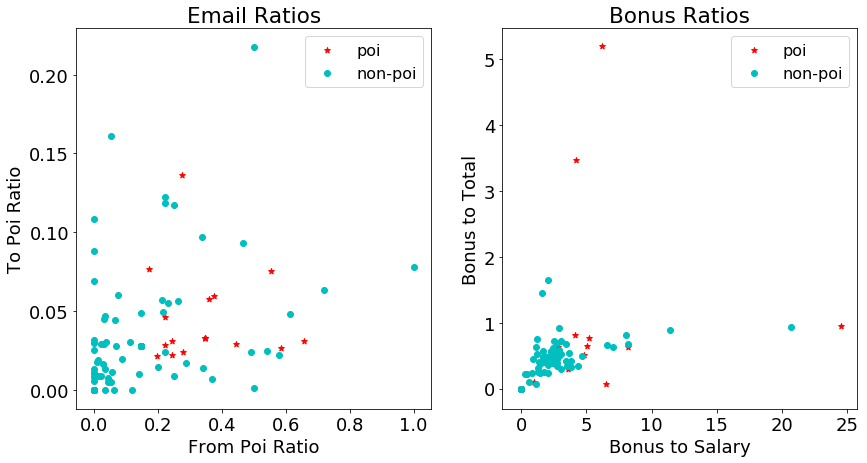

In [41]:
poi_df = df[df['poi']==True]
nonpoi_df = df[df['poi']==False]

plt.rcParams.update({'font.size':18})
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
plt.scatter(x=poi_df['from_poi_ratio'], y = poi_df['to_poi_ratio'], color = 'red', marker='*')
plt.scatter(x=nonpoi_df['from_poi_ratio'], y = nonpoi_df['to_poi_ratio'], color = 'c')
plt.xlabel('From Poi Ratio'); plt.ylabel('To Poi Ratio'); plt.title('Email Ratios'); 
plt.legend(['poi', 'non-poi'], prop= {'size': 16})

ax2 = fig.add_subplot(122)
plt.scatter(x=poi_df['bonus_to_salary'], y = poi_df['bonus_to_total'], color = 'red', marker='*')
plt.scatter(x=nonpoi_df['bonus_to_salary'], y = nonpoi_df['bonus_to_total'], color = 'c')
plt.xlabel('Bonus to Salary'); plt.ylabel('Bonus to Total'); plt.title('Bonus Ratios')
plt.legend(['poi', 'non-poi'], prop= {'size': 16})

The plot below is a scatter matrix showing all the relationships between the four selected features: 
- `bonus` 
- `total_payments` 
- `to_poi_ratio`
- `from_poi_ratio` 

The diagonals are histograms because a variable correlated with itself is simply one. The persons of interest are plotted in green and the non persons of interest are the blue points. 

Overall, there do seem to be a couple of trends. Looking at the `bonus` vs. `from_poi_ratio`, the persons of interest tend to be further to the right and higher than non persons of interest. This indicates that persons of interest tend to recieve larger bonuses and they send more emails to other persons of interest. 

From the scale on the total payments graph it can be seen that persons of interest tend to also have higher total payments. This trend can be seen in the `to_poi_ratio` vs. `total_payments` scatter plot. This could either indicate that persons of interest recieve more total payments due to fraudulent activity or they tend to recieve more total payments due to their employment at an upper level positions in the company that command higher salaries.

Overall, the visualizations do not offer many clear trends. However, it is still important to get a feel for the scale of the data and to check and see if there are any patterns evident that could inform the creation of new features or the selection of existing features.

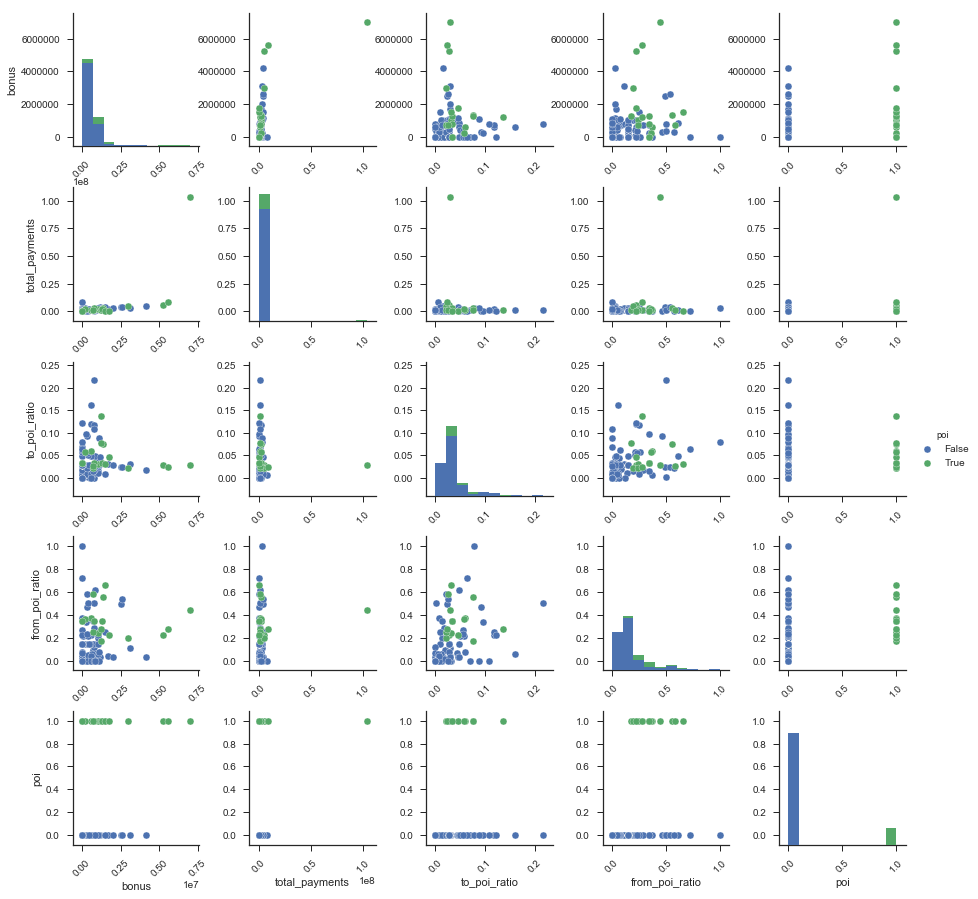

In [56]:
import seaborn as sns
sns.set(style="ticks")

df_scatter = df[['bonus',  'total_payments', 'to_poi_ratio', 'from_poi_ratio', 'poi']]

g = sns.pairplot(df_scatter, hue='poi', diag_kind="hist")
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

## Feature Selection 

There are several methods available for performing feature selection in machine learning. One is simply to look at the feature importances for a classifier and modify the list of features to exclude those with an importance below a chosen threshold. Another is to use [`SelectKBest`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) and have the k-best features, defined by the amount of variance explained, automatically selected for use in the classifier.

I will look at the feature/gini importances for both the `DecisionTree` and the `AdaBoost Classifier`, but I would prefer to use `SelectKBest` to actually choose the features to keep. Additionally, I can use [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) in combination with `SelectKBest` to find the optimal number of features to use. This will run through a number of k values and choose the one that yields the highest value according to a designated performance metric. 

First, I will manually look at the feature importances for both classifiers to get a sense of which features are most important. 

One of the most rewarding aspects of machine learning is that it enables humans with a higher sense of logical reasoning. By observing what the algorithm chooses as the most important features to identify persons of interest, humans can infer what they should be looking for in similar cases. (One example of this in the real world is when Google's AlphaGo defeated Lee Sedol in Go, it advanced the entire state of Go by providing new [insights and strategies](https://www.youtube.com/watch?v=D2iF9VpcBGw) into a game humans have played for a millenia.)

### Decision Tree Classifier

In [57]:
clf_tree = DecisionTreeClassifier()
clf_tree = verify.test_classifier(clf_tree, my_dataset, features_list)

	Accuracy: 0.93571	Precision: 0.76190	Recall: 0.80000	F1: 0.78049	F2: 0.79208
	Total predictions:  140	True positives:   16	False positives:    5	False negatives:    4	True negatives:  115



In [59]:
# Get the feature importances of the DecisionTree Classifier
tree_feature_importances = (clf_tree.feature_importances_)
tree_features = zip(tree_feature_importances, features_list[1:])
tree_features = sorted(tree_features, key= lambda x:x[0], reverse=True)

# Display the feature names and importance values
print('Decision Tree Classifier Feature/Gini Importances:\n')
for i in range(10):
    print('{} : {:.4f}'.format(tree_features[i][1], tree_features[i][0]))

Decision Tree Classifier Feature/Gini Importances:

from_poi_ratio : 0.3782
shared_receipt_with_poi : 0.2485
expenses : 0.2476
other : 0.0665
to_poi_ratio : 0.0592
salary : 0.0000
bonus : 0.0000
long_term_incentive : 0.0000
deferred_income : 0.0000
deferral_payments : 0.0000


### AdaBoost Classifier

In [62]:
from sklearn.ensemble import AdaBoostClassifier
clf_ada = AdaBoostClassifier()
clf_ada = verify.test_classifier(clf_ada, my_dataset, features_list)

	Accuracy: 0.92857	Precision: 0.75000	Recall: 0.75000	F1: 0.75000	F2: 0.75000
	Total predictions:  140	True positives:   15	False positives:    5	False negatives:    5	True negatives:  115



In [63]:
# Get the feature importances for the AdaBoost Classifier
ada_feature_importances = clf_ada.feature_importances_
ada_features = zip(ada_feature_importances, features_list[1:])

# Display the feature names and importance values
print('AdaBoost Classifier Feature/Gini Importances:\n')
ada_features = sorted(ada_features, key=lambda x:x[0], reverse=True)
for i in range(10):
    print('{} : {:.4f}'.format(ada_features[i][1], ada_features[i][0]))

AdaBoost Classifier Feature/Gini Importances:

shared_receipt_with_poi : 0.1400
from_poi_ratio : 0.1400
deferred_income : 0.1000
shared_poi_ratio : 0.1000
expenses : 0.0600
restricted_stock : 0.0600
from_poi_to_this_person : 0.0600
from_this_person_to_poi : 0.0600
to_poi_ratio : 0.0600
long_term_incentive : 0.0400


It is interesting to compare the feature importances for the `DecisionTree` and the `AdaBoost` classifiers. The top 10 features are not in close agreement even though both classifiers achieve a respectable F1 Score greater than 0.5. 

However, rather than manually selecting the features to keep, I will use `GridSearchCV` with `SelectKBest` to find the optimal number of features for the classifiers. 

`GridSearchCV` runs through a parameter grid and tests all the different configurations provided to it. It returns the parameters that yield the maximum score. I will use a scoring parameter of F1 because that is what I would like to maximize, and a cross-validation with 10 splits to ensure that I am not overfitting the algorithm to the training data.

In [148]:
from feature_format import featureFormat, targetFeatureSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

data_dict = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data_dict)

In [149]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV

n_features = np.arange(1, len(features_list))

# Create a pipeline with feature selection and classification
pipe = Pipeline([
    ('select_features', SelectKBest()),
    ('classify', DecisionTreeClassifier())
])

param_grid = [
    {
        'select_features__k': n_features
    }
]

# Use GridSearchCV to automate the process of finding the optimal number of features
tree_clf= GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv = 10)
tree_clf.fit(features, labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('select_features', SelectKBest(k=10, score_func=<function f_classif at 0x1a142c5400>)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'select_features__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [150]:
tree_clf.best_params_

{'select_features__k': 19}

In [120]:
tree_selection = SelectKBest(k=19)
tree_selection.fit_transform(features, labels)

tree_scores = tree_selection.scores_
tree_features = zip(tree_scores, features_list[1:])
tree_features = sorted(tree_features, key= lambda x:x[0], reverse=True)

print('Tree Feature F-statistics:\n')
for i in range(19):
    print('{} : {:.4f}'.format(tree_features[i][1], tree_features[i][0]))

Tree Feature F-statistics:

bonus : 36.2022
salary : 25.4609
from_poi_ratio : 25.2631
total_stock_value : 24.8372
exercised_stock_options : 24.0888
bonus_to_total : 20.8908
shared_receipt_with_poi : 20.4934
deferred_income : 17.0963
bonus_to_salary : 17.0251
from_poi_to_this_person : 15.9151
shared_poi_ratio : 13.2570
long_term_incentive : 12.7397
total_payments : 10.2104
restricted_stock : 10.0832
other : 7.9157
loan_advances : 7.0635
expenses : 5.7008
from_this_person_to_poi : 3.6437
to_messages : 2.7931


According to the grid search performed with `SelectKBest` with the number of features ranging from 1 to 24 (the number of features minus one), the __optimal number of features for the decision tree classifier is 19__. I can look at the scores assigned to the top performing features using the scores attribute of `SelectKBest`.

`SelectKBest` defaults to scoring parameters using the [`ANOVA F-value`](http://blog.minitab.com/blog/adventures-in-statistics-2/understanding-analysis-of-variance-anova-and-the-f-test) which is a measure of variation between sample means. 

It describes how much of the variance between labels is explained by a particular feature. A higher value therefore means that there is more variation in that feature between person of interests and non persons of interest. The following table summarizes the `Decision Tree` features and the `ANOVA F-Value` returned by `SelectKBest` with k = 19. These are the features I used in my final `DecisionTreeClassifier`. 

| Feature                 | F-statistic |
|:-----------------------:|-------------|
| bonus                   | 36.2022     |
| salary                  | 25.4609     |
| from_poi_ratio          | 25.2631     |
| total_stock_value       | 24.8372     |
| exercised_stock_options | 24.0888     |
| bonus_to_total          | 20.8908     |
| shared_receipt_with_poi | 20.4934     |
| deferred_income         | 17.0963     |
| bonus_to_salary         | 17.0251     |
| from_poi_to_this_person | 15.9151     |
| shared_poi_ratio        | 13.2570     |
| long_term_incentive     | 12.7397     |
| total_payments          | 10.2104     |
| restricted_stock        | 10.0832     |
| other                   | 7.9157      |
| loan_advances           | 7.0635      |
| expenses                | 5.7008      |
| from_this_person_to_poi | 3.6437      |
| to_poi_ratio            | 2.7931      |

In [152]:
tree_clf = Pipeline([
    ('select_features', SelectKBest(k=19)),
    ('classify', DecisionTreeClassifier()),
])

verify.dump_classifier_and_data(tree_clf, my_dataset, features_list)
verify.main()

	Accuracy: 0.93571	Precision: 0.82353	Recall: 0.70000	F1: 0.75676	F2: 0.72165
	Total predictions:  140	True positives:   14	False positives:    3	False negatives:    6	True negatives:  117



Running the `DecisionTreeClassifier` with `SelectKMeans` and k = 19 yields an F1 score of 0.75676. The F1 score obtained matches my expectations and I have decided on the 19 features I will use with the `DecisionTreeClassifier`. Any further improvement of this classifier is possible with the parameter tuning section of the initial investigation.

A similar procedure with `GridSearchCV` and `SelectKBest` will be carried out to determine the optimal number of features to use with the `AdaBoostClassifier`.

In [158]:
n_features = np.arange(1, len(features_list))
# Create a pipeline of feature selection and classifier
pipe = Pipeline([
    ('select_features', SelectKBest()),
    ('classify', AdaBoostClassifier())
])

param_grid = [
    {
        'select_features__k': n_features
    }
]

# Use GridSearchCV to automate the process of finding the optimal number of features
ada_clf= GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv =10)
ada_clf.fit(features, labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('select_features', SelectKBest(k=10, score_func=<function f_classif at 0x1a142c5400>)), ('classify', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'select_features__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [159]:
ada_clf.best_params_

{'select_features__k': 18}

In [160]:
ada_clf.best_score_

0.6628571428571428

In [161]:
ada_selection = SelectKBest(k=18)
ada_selection.fit_transform(features, labels)

ada_scores = ada_selection.scores_
ada_features = zip(ada_scores, features_list[1:])
ada_features = sorted(ada_features, key= lambda x:x[0], reverse=True)

print('AdaBoost Features F-statistics:\n')
for i in range(18):
    print('{} : {:.4f}'.format(ada_features[i][1], ada_features[i][0]))

AdaBoost Features F-statistics:

bonus : 36.2022
salary : 25.4609
from_poi_ratio : 25.2631
total_stock_value : 24.8372
exercised_stock_options : 24.0888
bonus_to_total : 20.8908
shared_receipt_with_poi : 20.4934
deferred_income : 17.0963
bonus_to_salary : 17.0251
from_poi_to_this_person : 15.9151
shared_poi_ratio : 13.2570
long_term_incentive : 12.7397
total_payments : 10.2104
restricted_stock : 10.0832
other : 7.9157
loan_advances : 7.0635
expenses : 5.7008
from_this_person_to_poi : 3.6437


In [162]:
verify.dump_classifier_and_data(ada_clf, my_dataset, features_list)
verify.main()

	Accuracy: 0.90714	Precision: 0.68421	Recall: 0.65000	F1: 0.66667	F2: 0.65657
	Total predictions:  140	True positives:   13	False positives:    6	False negatives:    7	True negatives:  114



The ideal number of parameters for `SelectKMeans` using `GridSearch` for the `AdaBoostClassifier` was 18. This resulted in a slightly lower F1 score of 0.66667 and I will use the 18 highest scoring features with the `AdaBoostClassifier`. The F-Scores are the same so I will not compute them again.

At this point I could also perform Principal Component Analysis to further reduce the number of features, but I feel this performance does not necessitate the use of PCA, and the algorithms do not take very long to train even on a large number of features. 

PCA creates new features by selecting dimensions of data with the greatest variation even if these features do not necessarily represent actual quantifiable values in the dataset. It's preferable to know the most ideal features to select for the model if that is possible. This is one way I'm trying to combat the black box problem in machine learning. If I am aware of what parameters exactly constitute my model, then I can try to understand why my model returned a certain classification and it can enable me with valuable insights to create smarter machine learning classifiers in the future.

## Algorithm Parameter Tuning

Parameter tuning is the process of optimizing the "settings" of a machine learning algorithm to achieve maximum performance on a given dataset. A machine learning [algorithm](http://csfieldguide.org.nz/en/chapters/algorithms.html) is simply a sequence of rules that is applied to a set of features by a computer in order to arrive at a classification. Parameter tuning can be thought of as iteratively altering these rules to produce better classifications. 

`Sci-kit learn` implements default parameters for each algorithm designed to get a classifier up and running by generalizing to as many datasets as possible with decent performance. However, it is possible to achieve greater performance by changing these algorithm parameters (although they are often used interchangeably, technically 'hyperparameters' are aspects of the estimator that must be set beforehand by the user while the model 'parameters' are learned from the dataset; [see here for a discussion](https://stats.stackexchange.com/questions/149098/what-do-we-mean-by-hyperparameters)). 

The proces of parameter tuning for a dataset can either by carried out manually, by selecting different configurations, performing cross-validation, and selecting the settings that return the highest performance, or it can be automated by another algorithm such as `GridSearchCV`. A parameter grid is passed to `GridSearchCV` that consists of a number of combinations of parameters to test with an algorithm, and the search returns the parameters that maximize performance. The parameters available for an algorithm in `sci-kit learn` can be found in the classifier documentation. My process for algorithm tuning will be to examine the `sci-kit learn` documentation, construct a parameter grid with a wide range of configurations, and use `GridSearchCV` to find the optimal settings. 

Looking at the `sci-kit learn` [documentation for the DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), there are numerous parameters that can be changed, each of which alter the manner in which the algorithm makes decisions as it parses the features and creates the 'tree'. 

For example, `criterion` can either be set as `gini` or `entropy` which determines how the algorithm measures the quality of a split of a node, or in other words, which branch of the tree to take to arrive at the correct classification. (`gini` utilizies the [`gini impurity`](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) while `entropy` maximizes the [`information gain`](https://en.wikipedia.org/wiki/Information_gain_ratio) at each branching. I will put both options in my parameter grid and let grid search determine which is the best. 

The other three parameters I will tune are `min_samples_split`, `max_depth`, and `max_features`. `GridSearch` will be directed by cross-validation with 10 splits of the data, and the scoring criteria is specified as `F1` because that is the primary measure of classifier performance I used to account for both precision and recall. 

In [163]:
# Create a pipeline with feature selection and classifier
tree_pipe = Pipeline([
    ('select_features', SelectKBest(k=19)),
    ('classify', DecisionTreeClassifier()),
])

# Define the configuration of parameters to test with the 
# Decision Tree Classifier
param_grid = dict(classify__criterion = ['gini', 'entropy'] , 
                  classify__min_samples_split = [2, 4, 6, 8, 10, 20],
                  classify__max_depth = [None, 5, 10, 15, 20],
                  classify__max_features = [None, 'sqrt', 'log2', 'auto'])

# Use GridSearchCV to find the optimal hyperparameters for the classifier
tree_clf = GridSearchCV(tree_pipe, param_grid = param_grid, scoring='f1', cv=10)
tree_clf.fit(features, labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('select_features', SelectKBest(k=19, score_func=<function f_classif at 0x1a142c5400>)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'classify__criterion': ['gini', 'entropy'], 'classify__min_samples_split': [2, 4, 6, 8, 10, 20], 'classify__max_depth': [None, 5, 10, 15, 20], 'classify__max_features': [None, 'sqrt', 'log2', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [164]:
tree_clf.best_score_

0.8585714285714285

In [165]:
# Get the best algorithm hyperparameters for the Decision Tree Classifier
tree_clf.best_params_

{'classify__criterion': 'entropy',
 'classify__max_depth': 5,
 'classify__max_features': None,
 'classify__min_samples_split': 20}

In [178]:
# Create the classifier with the optimal hyperparameters as found by GridSearchCV
tree_clf = Pipeline([
    ('select_features', SelectKBest(k=20)),
    ('classify', DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=None, min_samples_split=20))
])

# Test the classifier using verify.py
verify.dump_classifier_and_data(tree_clf, my_dataset, features_list)
verify.main()

	Accuracy: 0.97143	Precision: 0.86364	Recall: 0.95000	F1: 0.90476	F2: 0.93137
	Total predictions:  140	True positives:   19	False positives:    3	False negatives:    1	True negatives:  117



According to the cross validation in [`verify.py`](verify.py), my F1 score is around 0.90476 with the optimal parameters.

Here is a brief summary of the results using `GridSearch` for feature selection and then for algorithm tuning.

**`Decision Tree Classifier`**:

| Parameter         | SelectKBest | criterion | max_depth | max_features | min\_samples\_split |
|------------------ |-------------|-----------|-----------|--------------|---------------------|
| __Optimal Value__ |      19     | 'entropy' |    5      |     None     |          20         |

In my final step I implement my best performing classifier, the `Decision Tree Classifier`, with the optimal parameters obtained and judge its final performance using my tester function within [`verify.py`](verify.py). 

In [192]:
# Implement the Decision Tree Classifier with the optimal parameters
tree_clf = Pipeline([
    ('select_features', SelectKBest(k=19)),
    ('classify', DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=None, min_samples_split=20))
])

# Test the classifier with cross-validation
verify.dump_classifier_and_data(tree_clf, my_dataset, features_list)
verify.main()

	Accuracy: 0.97143	Precision: 0.86364	Recall: 0.95000	F1: 0.90476	F2: 0.93137
	Total predictions:  140	True positives:   19	False positives:    3	False negatives:    1	True negatives:  117



The results from running the final version of the algorithm is shown below:

| Algorithm                | Precision | Recall | F1 Score | Accuracy |
|--------------------------|-----------|--------|----------|----------|
| Decision Tree Classifier | 0.86364   | 0.95000| 0.90476  | 0.97143  |

## Conclusion

Although the script I used to test the classifier implemented cross-validation, I was skeptical of the relatively high precision, recall, and F1 score recorded. I was conscious that I had somehow overfit my model to the data even though the script implements cross-validation. 

Looking through the [`verify.py`](verify.py) script, I saw that the [random seed](https://en.wikipedia.org/wiki/Random_seed) for the cross-validation split was set at 42 in order to generate reproducible results. I changed the random seed and sure enough, the performance of my model decreased. 

Therefore, I must have made the classic mistake of overfitting on my training set for the given cross-validation random seed, and I will need to look out for this problem in the future. Even taking precuations against overfitting, I had still optimized my model for a specific set of data. 

In order to get a better indicator of the perfomance of the `Decision Tree` model, I ran 10 tests with different random seeds and found the average performance metrics. 

The final results for my model are summarized below:

| Algorithm                | Precision | Recall | F1 Score | Accuracy |
|--------------------------|-----------|--------|----------|----------|
| Decision Tree Classifier | 0.76190   | 0.80000| 0.78049  | 0.93571  |


The results are still relatively high given the nature of the persons of interest identification task, but not as suspiciously outstanding as before. 

__A precision score of 0.76190 means that of the individuals labeled by my model as persons of interest, 76.19% of them were indeed persons of interest. A recall score of 0.80000 means that my model identified 80.0% of persons of interest present in the entire dataset.__ 

The main takeaway from this project was the importance of quality relevant data as compared to fine-tuning the algorithm. Feature engineering, through the creation of new features and the selection of those with the greatest explained variance, increased the F1 score of the classifier from ~ 0.50 to ~ 0.70. However, tuning the hyperparameters of the algorithm only increased the F1 score to 0.80. 